In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from pylops.optimization.leastsquares import *
from refrtomo.invert import *
from refrtomo.survey import *

/home/bermanu/miniconda3/envs/refrtomo/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In this notebook we invert for the marmousi velocity model (a little bigger than in the previous script) by using the best method, which is the **'proper' gauss-newton**, which is actually LSQR done with the sensitivity matrix or jacobian (tomographic matrix) and the residual data, to compute the perturbation on the initial slowness vect. 

There are two study cases:

* Surface Geometry
* VSP Geometry

Sadly, the raytracer is not capable of dealing with the cross-hole geometry since its using the rays that are turning and, in this case, we required the direct rays (this means direct arrivals rather than refracted arrivals). The cross-hole geometry would have been a better test to get a coverage on the whole model.

In [2]:
#%% Velocity Model
nx, nz = 1360, 280
dx, dz = 2., 2.

vel_true = np.fromfile("../data/marmousi.bin", dtype='float32', sep="")
vel_true = vel_true.reshape(nx, nz)[50:600, 80:180] 
# vel_true = vel_true.reshape(nx, nz)[100:500, 80:210]
nx, nz = vel_true.shape
x, z = np.arange(nx) * dx, np.arange(nz) * dz

# Smoothed velocity
nsmooth = 10
vel_smooth = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_smooth = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_smooth, axis=1)

# Create gradient model for the initial velocity
vel_initial = np.tile(1100 + 12 * z, (nx, 1))

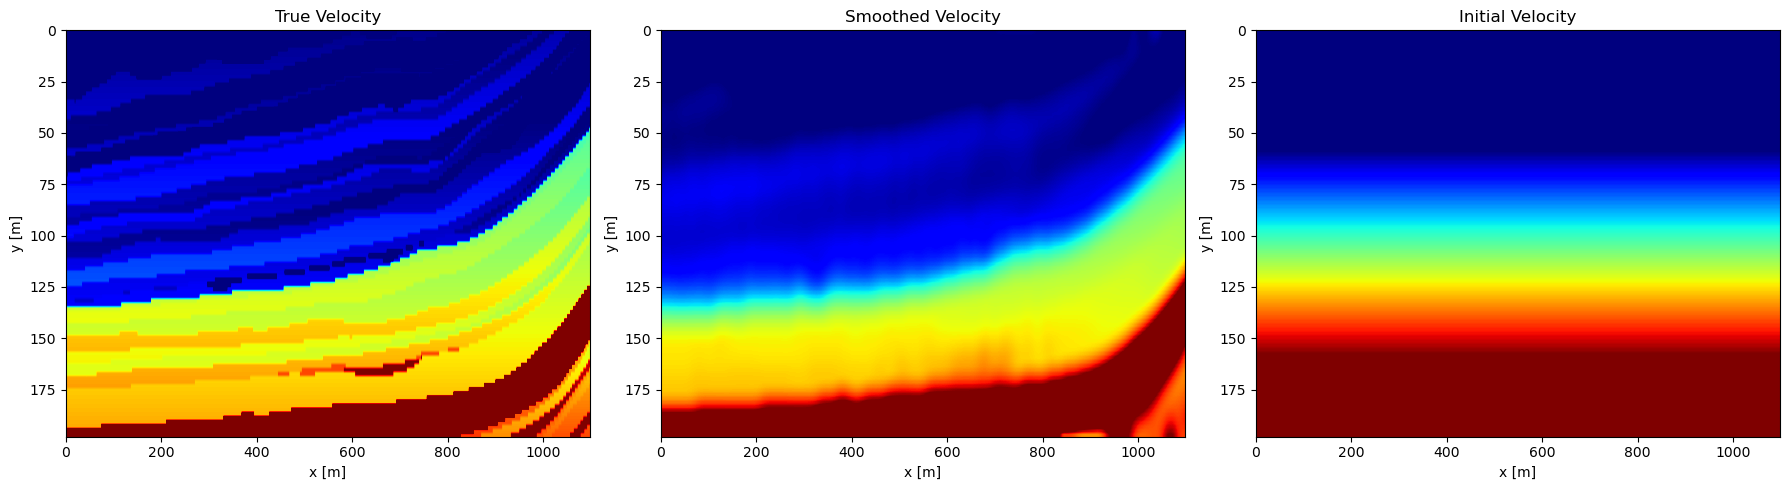

In [3]:
# Set velocity parameters
vmin = 1800; vmax = 3000

# Plot Velocity Models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Actual velocity
im = axes[0].imshow(vel_true.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[0].set_title('True Velocity')
axes[0].set_xlabel('x [m]')
axes[0].set_ylabel('y [m]')
axes[0].set_ylim(z[-1], z[0])
axes[0].axis('tight')

# Smoothed velocity
im = axes[1].imshow(vel_smooth.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[1].set_title('Smoothed Velocity')
axes[1].set_xlabel('x [m]')
axes[1].set_ylabel('y [m]')
axes[1].set_ylim(z[-1], z[0])
axes[1].axis('tight')

# Initial velocity
im = axes[2].imshow(vel_initial.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[2].set_title('Initial Velocity')
axes[2].set_xlabel('x [m]')
axes[2].set_ylabel('y [m]')
axes[2].set_ylim(z[-1], z[0])
axes[2].axis('tight')

plt.tight_layout()
plt.show()

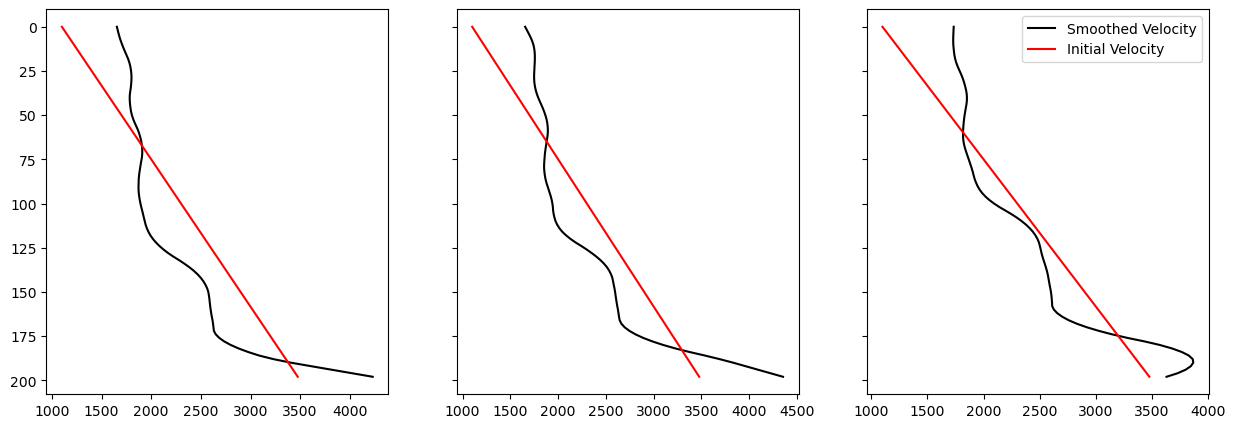

In [4]:
# Plot vel profiles
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_smooth[ix], z, 'k', label = 'Smoothed Velocity')
    ax.plot(vel_initial[ix], z, 'r', label = 'Initial Velocity')
axs[-1].invert_yaxis()
plt.legend()
plt.show()

## 1) Surface Geometry

In [5]:
#%% Geometry
geometry = 'Surface'
ns = 15
nr = 25
s = np.empty((2, ns))
r = np.empty((2, nr))
max_x = x[-1]
max_z = z[-1]
if geometry == 'Crosshole':
    s[0, :ns] = 5 * dx
    s[1, :ns] = np.linspace(5 * dz, max_z - 5 * dz, ns)
    r[0, :nr] = max_x - 5 * dx
    r[1, :nr] = np.linspace(5 * dz, max_z - 5 * dz, nr)

elif geometry == 'VSP':
    s[0, :ns] = np.linspace(7.5 * dx, max_x - 7.5 * dx, ns)
    s[1, :ns] = 2.5 * dz
    r[0, :nr] = max_x / 2
    r[1, :nr] = np.linspace(2.5 * dz, max_z - 2.5 * dz, nr)

elif geometry == 'Surrounded':
    s[0, :ns//2] = 5 * dx
    s[1, :ns//2] = np.linspace(5 * dz, max_z - 5 * dz, ns//2)
    r[0, :nr//2] = max_x - 5 * dx
    r[1, :nr//2] = np.linspace(5 * dz, max_z - 5 * dz, nr//2)

    s[1, ns//2:] = 5 * dz
    s[0, ns//2:] = np.linspace(5 * dx, max_x - 5 * dx, ns//2)
    r[1, nr//2:] = max_z - 5 * dz
    r[0, nr//2:] = np.linspace(5 * dx, max_x - 5 * dx, nr//2)

elif geometry == 'Surface':
    r[0, :] = np.linspace(4 * dx, max_x - 4 * dx, nr)
    r[1, :] = 0
    s[0, :] = np.linspace(2 * dx, max_x - 2 * dx, ns)
    s[1, :] = 0

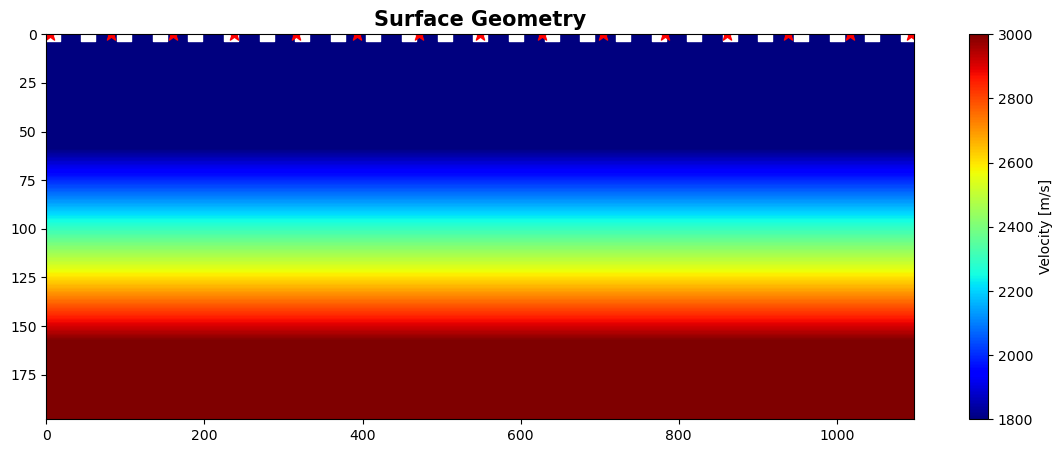

In [6]:
# Create the survey
survey = survey_geom(s, r, minoffset=50)

# Plot geometry
plt.figure(figsize=(14, 5))
im = plt.imshow(vel_initial.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar(im, label='Velocity [m/s]')
plt.scatter(r[0], r[1], c='w', s=100, marker='s')
plt.scatter(s[0], s[1], c='r', s=100, marker='*')

plt.title('Surface Geometry', fontsize=15, fontweight='bold')
plt.axis('tight')
plt.show()

In [7]:
#%% Inverse crime
lmax = 1e3
nl = 2000
thetas = np.hstack([np.arange(-85, -0.5, 0.1), np.arange(0.5, 85, 0.1)])
avasurvey = survey_raytrace(survey, vel_smooth.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=3., debug=True)

# # Display observed traveltimes
# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# for isrc in range(ns):
#     display_survey_tobs(avasurvey, s[0][isrc], ax=ax)
# plt.title('Observed Travel Times')
# plt.show()

survey_raytrace: 342 Source-receiver pairs in survey, 180 Source-receiver paired with ray...


In [8]:
# Create tomographic matrix 
Robs = tomographic_matrix(avasurvey, dx, dz, 0, 0, nx, nz, x, z, plotflag=False, vel=vel_smooth)

tobs_real = extract_tobs(avasurvey)
tobs_real_R = Robs @ (1/vel_smooth.ravel())

As shown below, the matrix is not actually bad conditioned, so pre-conditioning is not necessary.

Any zero singular values: False
Condition number of the matrix: 5.65


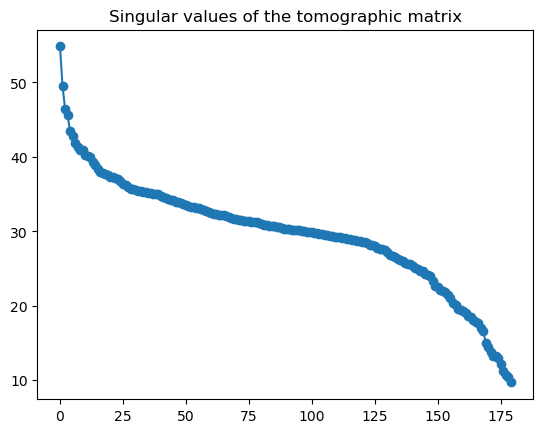

In [9]:
# Compute and plot the singular values of the tomographic matrix
U, s, Vh = np.linalg.svd(Robs.toarray(), full_matrices=False)
print('Any zero singular values:', np.any(s == 0))

# Print the condition number of the matrix
print(f"Condition number of the matrix: {np.round(np.linalg.cond(Robs.toarray()),2)}")

plt.figure()
plt.plot(s, 'o-')
# plt.yscale('log')
plt.title('Singular values of the tomographic matrix')
plt.show()

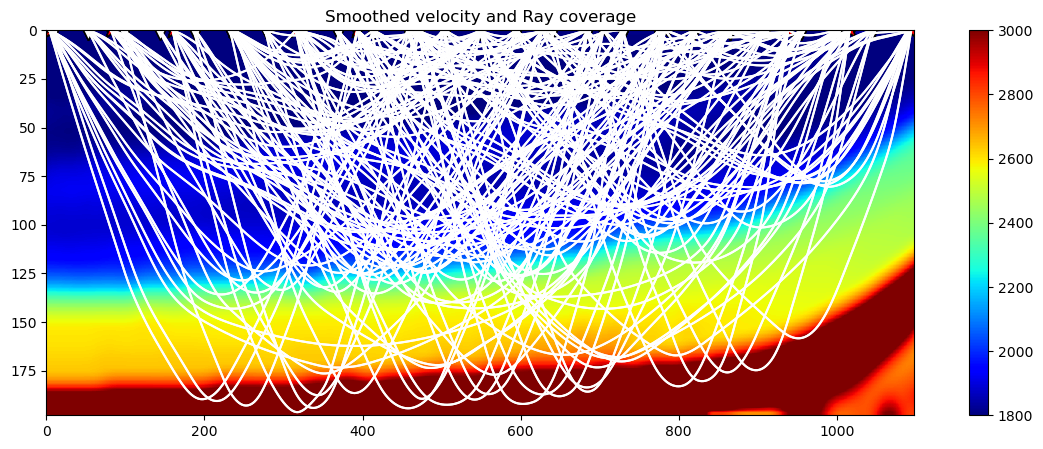

In [10]:
# Ray coverage
plt.figure(figsize=(14, 5))
im = plt.imshow(vel_smooth.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]), vmin=vmin, vmax=vmax)
plt.colorbar(im)
for ss in avasurvey:
    src = ss.src
    plt.scatter(src[0], src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ss.rec[0], ss.rec[1], marker='v', s=200, c='w', edgecolors='k')

    for irec, rec in enumerate(ss.rec):
        plt.plot(ss.ray[:,0], ss.ray[:,1], 'w')
plt.axis('auto')
plt.title('Smoothed velocity and Ray coverage')
plt.show()

Show the difference between the analytical and numerical (tomographic) true travel times.

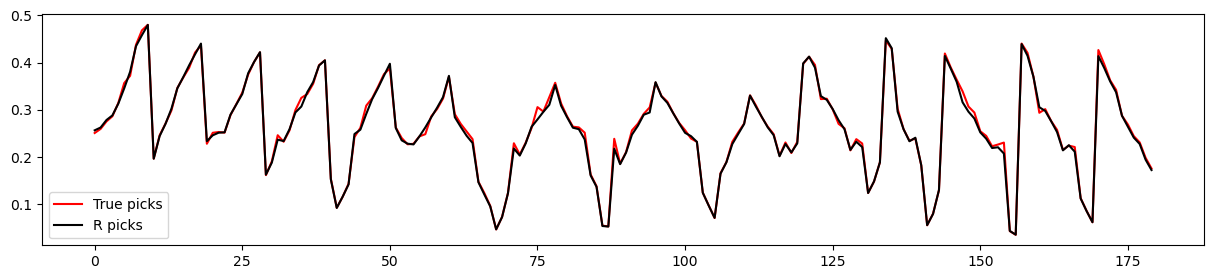

In [11]:
# Plot observed and predicted picks
plt.figure(figsize=(15, 3))
plt.plot(tobs_real, 'r', label= "True picks")
plt.plot(tobs_real_R, 'k', label = "R picks")
plt.legend()
plt.show()

In [12]:
#%% Initial rays and traveltimes
initsurvey = survey_raytrace(survey, vel_initial.T, x, z, lmax, nl, thetas, dzout=1., ray_rec_mindistance=3., debug=True)

# Match surveys
avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey, debug=True)

# Tomographic matrix and traveltimes
Rinit = tomographic_matrix(initsurvey_matched, dx, dz, 0, 0, nx, nz, x, z,
                           plotflag=False, vel=vel_initial, figsize=(15, 3))

# Extract traveltimes
tobs = extract_tobs(avasurvey_matched)
tobs_init = extract_tobs(initsurvey_matched)
tinit = Rinit @ (1/vel_initial.ravel())

survey_raytrace: 342 Source-receiver pairs in survey, 165 Source-receiver paired with ray...
match_surveys: 180 Rays in survey1, 165 Rays in survey2, 68 Matched rays...


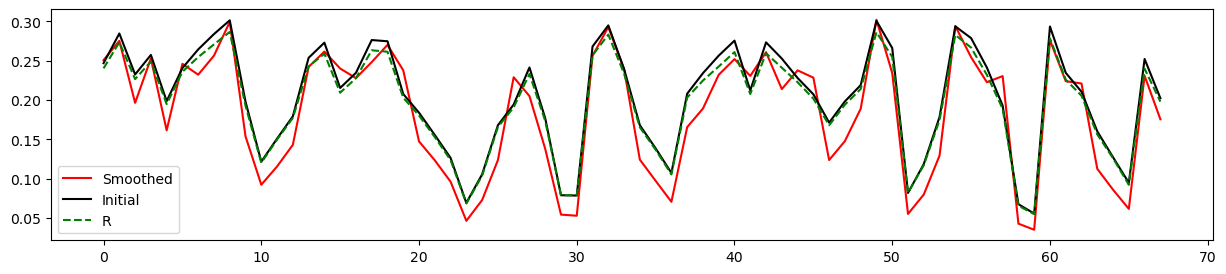

In [13]:
# Observed traveltimes vs Initial Guess
initial_Rinit = Rinit.copy()
initial_tobs_init = tobs_init.copy()

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r', label = 'Smoothed')
plt.plot(tobs_init, 'k', label = 'Initial')
plt.plot(tinit, '--g', label = 'R')
plt.legend()
plt.show()

We must start slowly decreasing the values of either the damping factor or the weighting terms, to allow for more flexibility in the update of the model without getting weird, not geologically plausible results.

Iteration 1/6
RefrTomo-fun: Computing...
survey_raytrace: 342 Source-receiver pairs in survey, 165 Source-receiver paired with ray...
match_surveys: 180 Rays in survey1, 165 Rays in survey2, 68 Matched rays...
tomographic_matrix: 68 rows, 55000 columns
RefrTomo-fun: Misfit 0.0032
RefrTomo-fun: Elapsed time 37.01934313774109 s...
Iteration 2/6
RefrTomo-fun: Computing...
survey_raytrace: 342 Source-receiver pairs in survey, 157 Source-receiver paired with ray...
match_surveys: 180 Rays in survey1, 157 Rays in survey2, 64 Matched rays...
tomographic_matrix: 64 rows, 55000 columns
RefrTomo-fun: Misfit 0.0028
RefrTomo-fun: Elapsed time 42.37359881401062 s...
Iteration 3/6
RefrTomo-fun: Computing...
survey_raytrace: 342 Source-receiver pairs in survey, 163 Source-receiver paired with ray...
match_surveys: 180 Rays in survey1, 163 Rays in survey2, 65 Matched rays...
tomographic_matrix: 65 rows, 55000 columns
RefrTomo-fun: Misfit 0.0031
RefrTomo-fun: Elapsed time 40.92717671394348 s...
Iterati

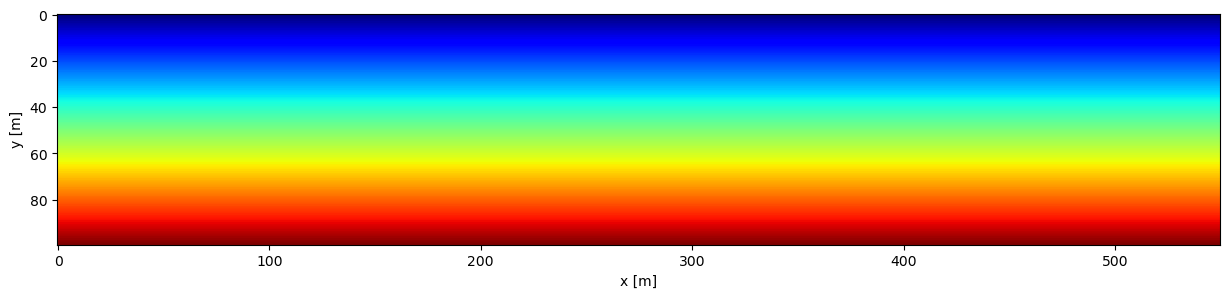

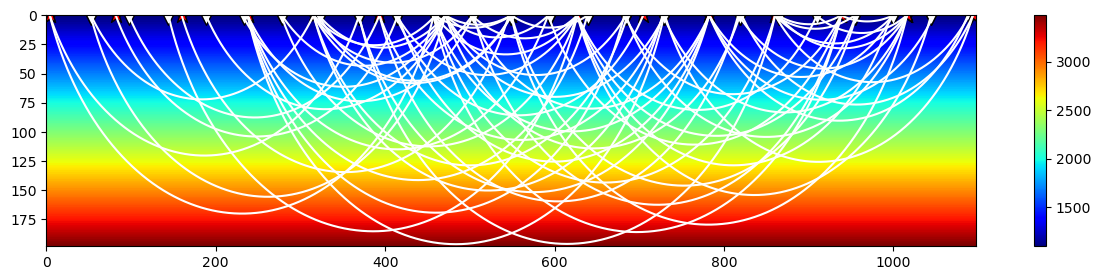

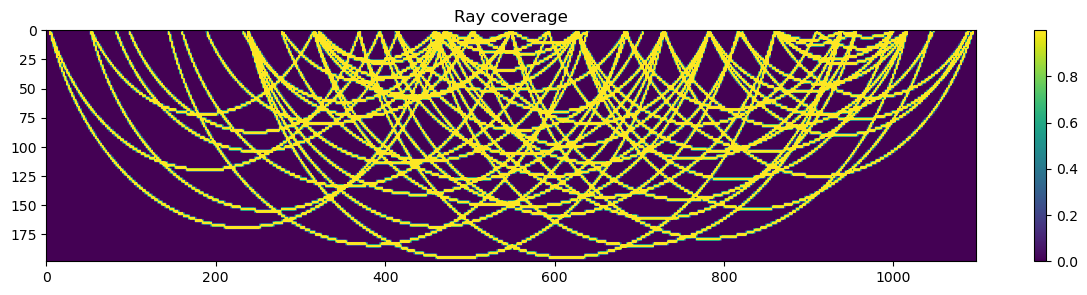

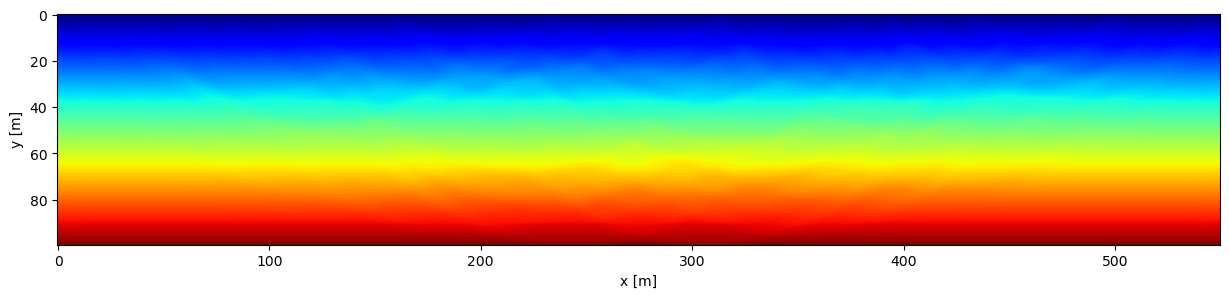

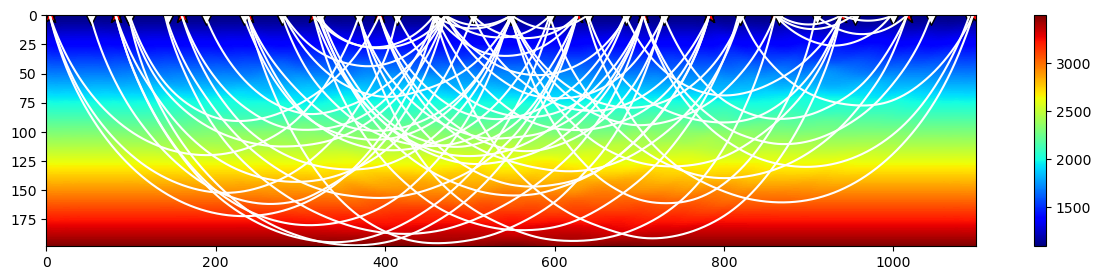

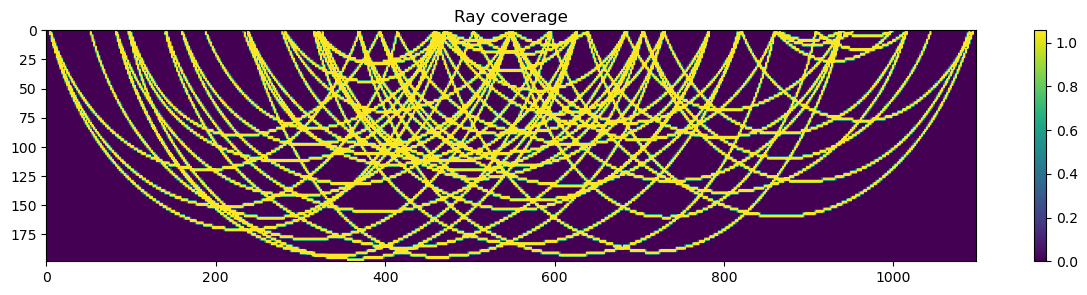

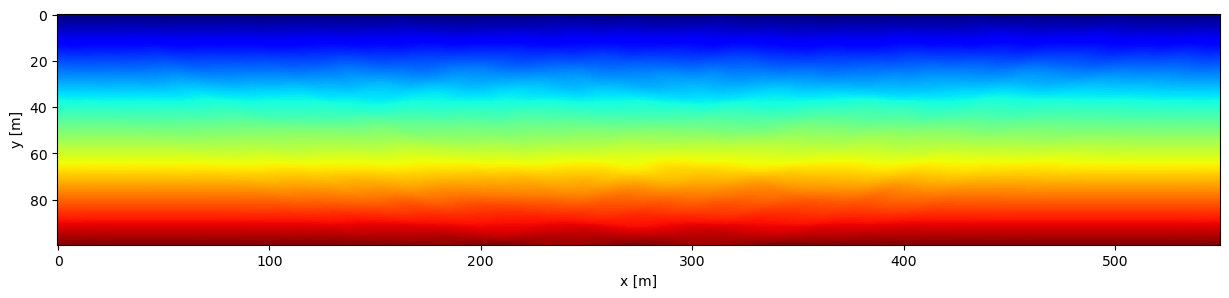

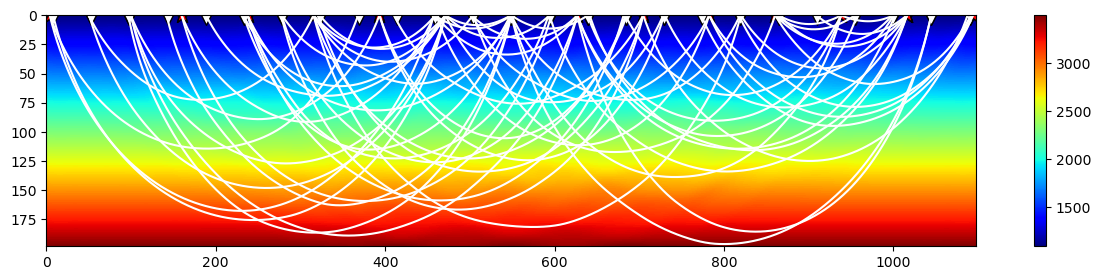

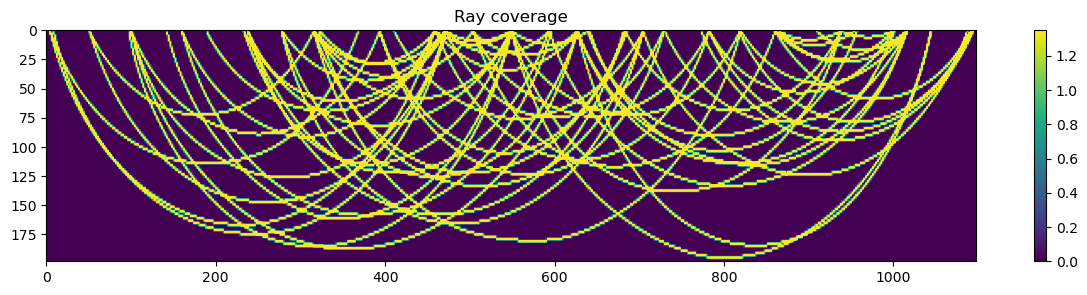

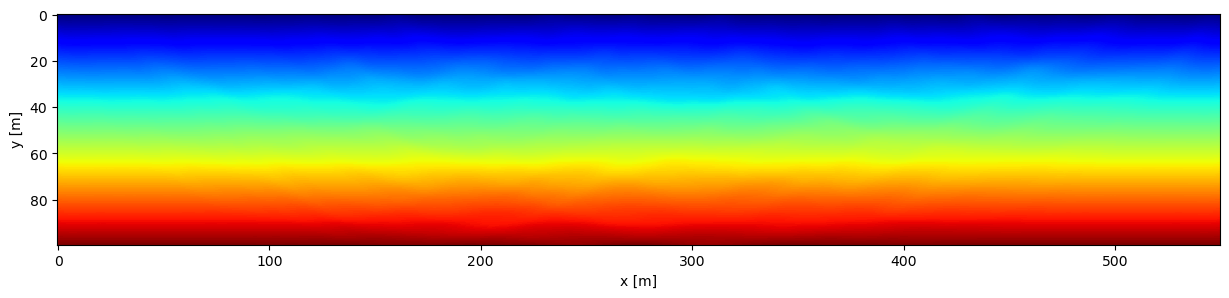

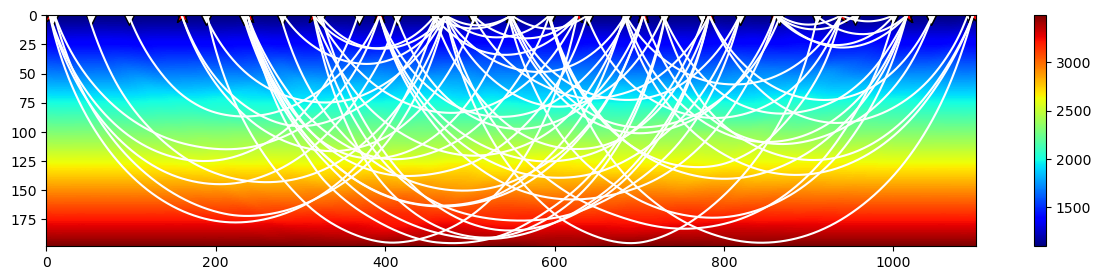

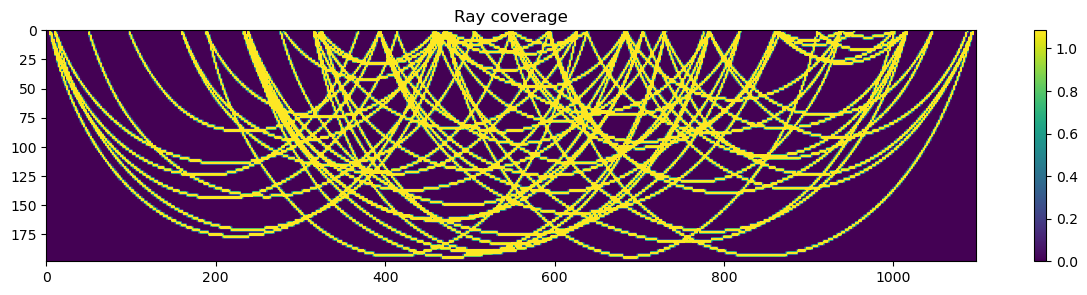

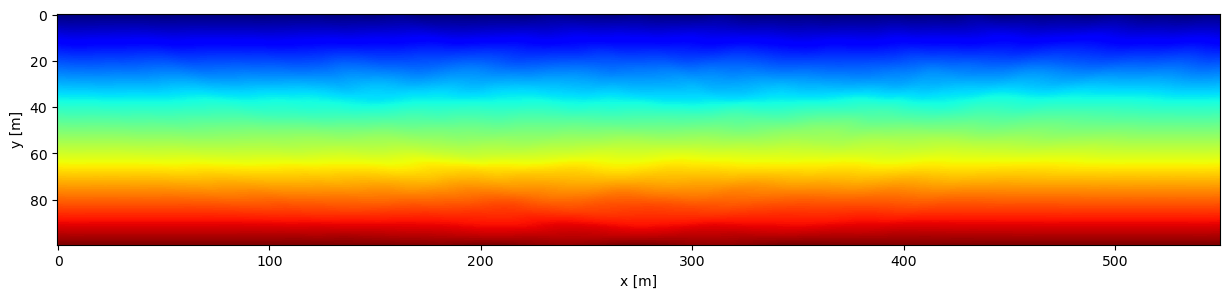

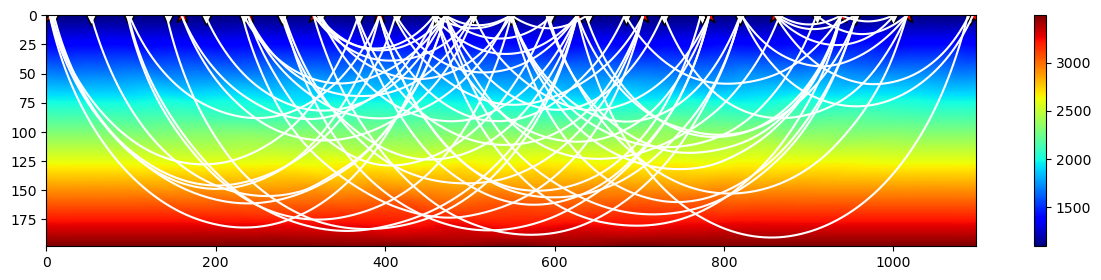

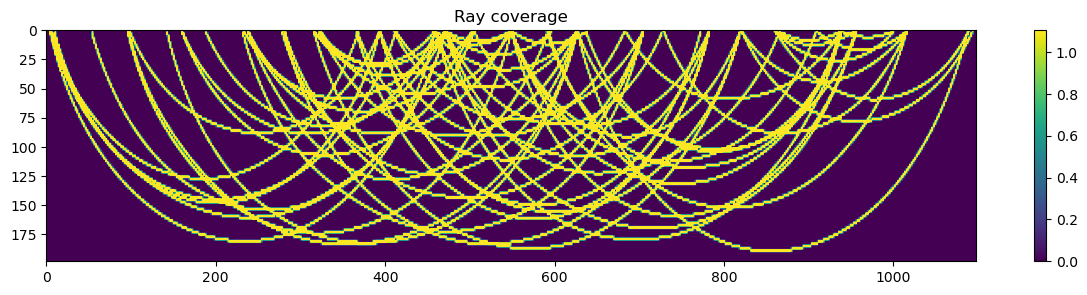

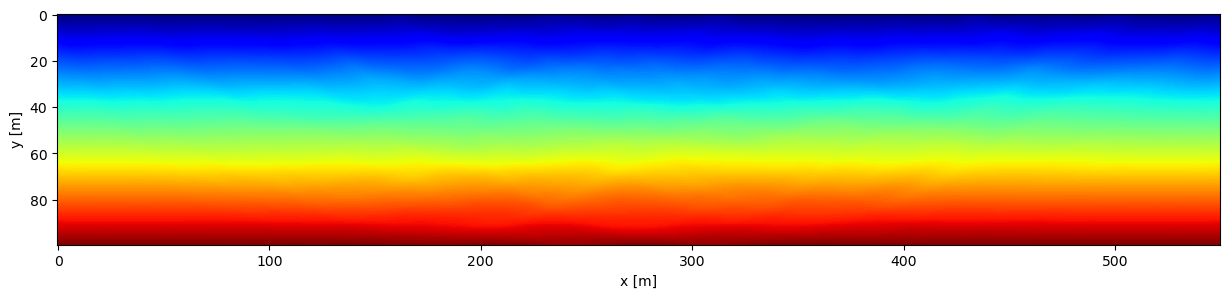

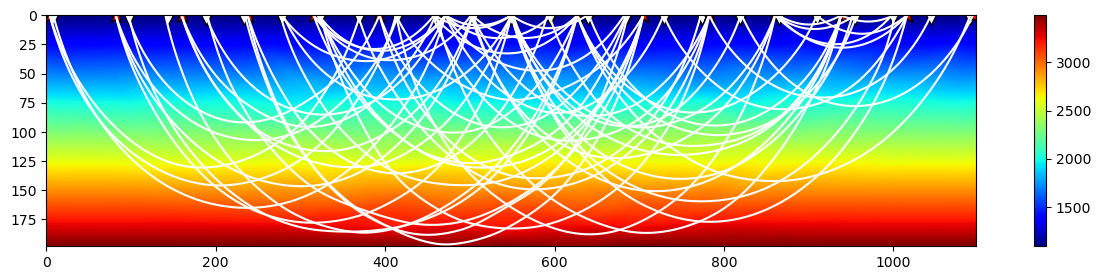

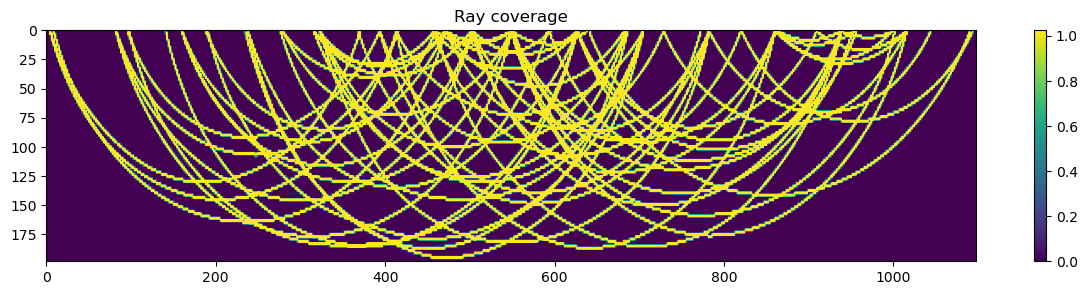

In [14]:
#%% Proper Gauss-Newton Method
RTomo_surface = RefrTomo(survey, avasurvey, x, z, lmax, nl, thetas, dzout=1.,
                 ray_rec_mindistance=3., epsL=3e1, weightsL=(20, 10), returnJ=True,
                 debug=True)
vel_gauss_surface, misfit_gauss_surface = RTomo_surface.solve(vel_initial, niter=6, damp=1.3e0, lsqr_args=dict(iter_lim=30, show=False))

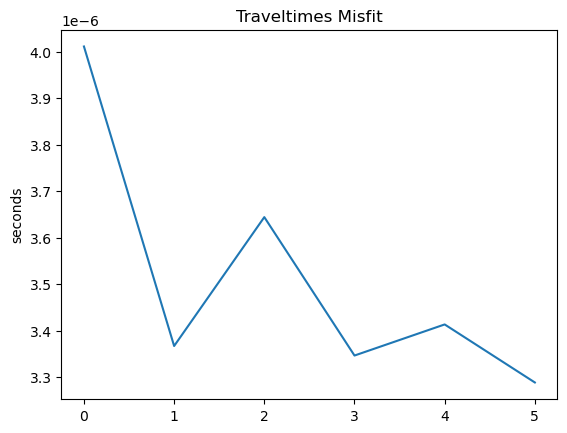

In [15]:
# Plot misfit
plt.figure()
plt.plot(misfit_gauss_surface)
plt.title('Traveltimes Misfit')
plt.ylabel('seconds')
plt.show()

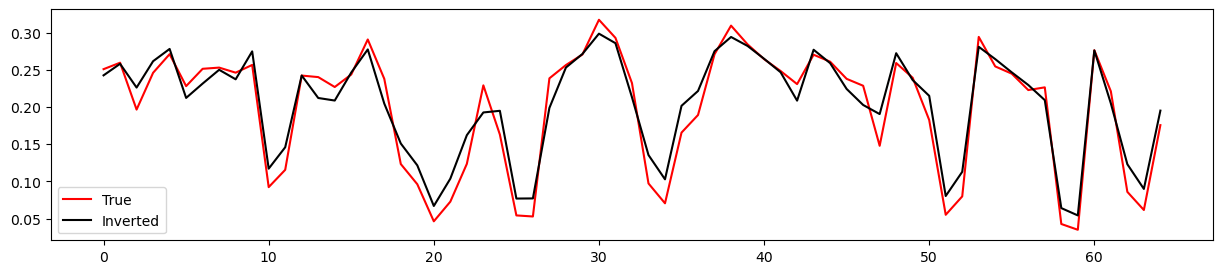

In [16]:
# Extract the final traveltimes from the RTomo object
tobs = RTomo_surface.tobs
tinv = RTomo_surface.tinv

# Plot the true and inverted traveltimes
plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r', label = 'True')
plt.plot(tinv, 'k', label = 'Inverted')
plt.legend()
plt.show()

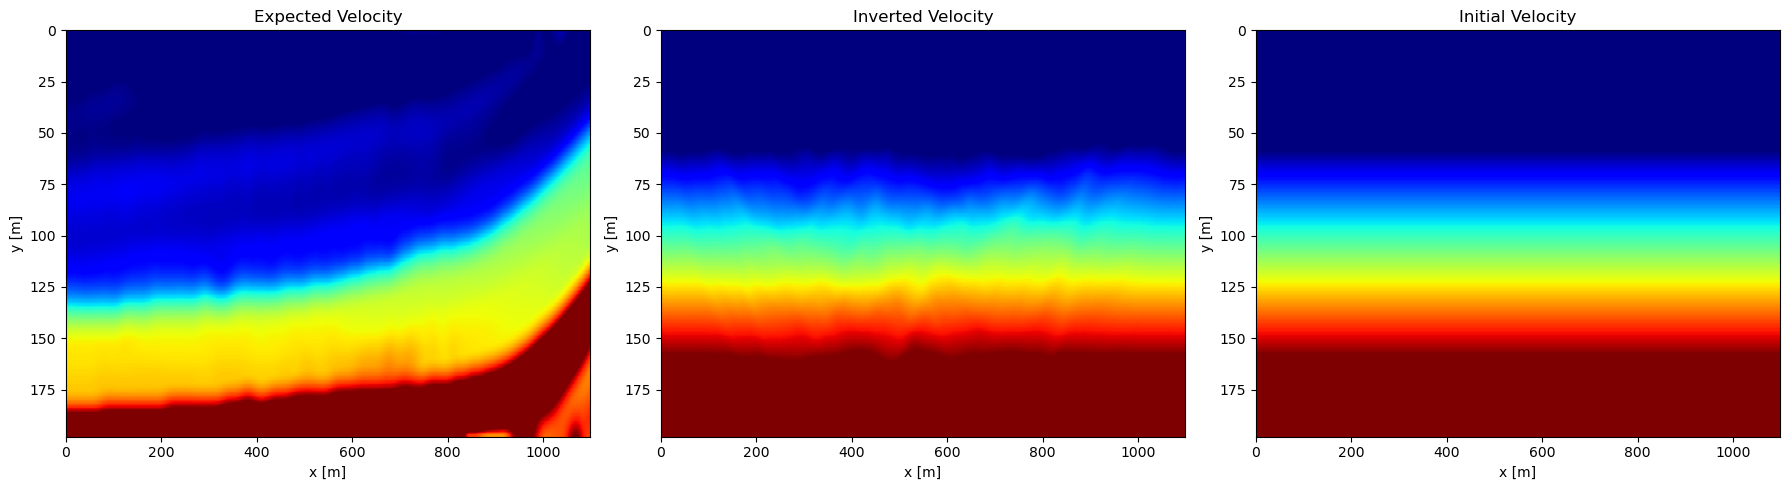

In [17]:
# Show results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# True velocity (smooth)
im = axes[0].imshow(vel_smooth.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[0].set_title('Expected Velocity')
axes[0].set_xlabel('x [m]')
axes[0].set_ylabel('y [m]')
axes[0].set_ylim(z[-1], z[0])
axes[0].axis('tight')

# Inverted velocity
im = axes[1].imshow(vel_gauss_surface.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[1].set_title('Inverted Velocity')
axes[1].set_xlabel('x [m]')
axes[1].set_ylabel('y [m]')
axes[1].set_ylim(z[-1], z[0])
axes[1].axis('tight')

# Initial velocity
im = axes[2].imshow(vel_initial.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
axes[2].set_title('Initial Velocity')
axes[2].set_xlabel('x [m]')
axes[2].set_ylabel('y [m]')
axes[2].set_ylim(z[-1], z[0])
axes[2].axis('tight')

plt.tight_layout()
plt.show()

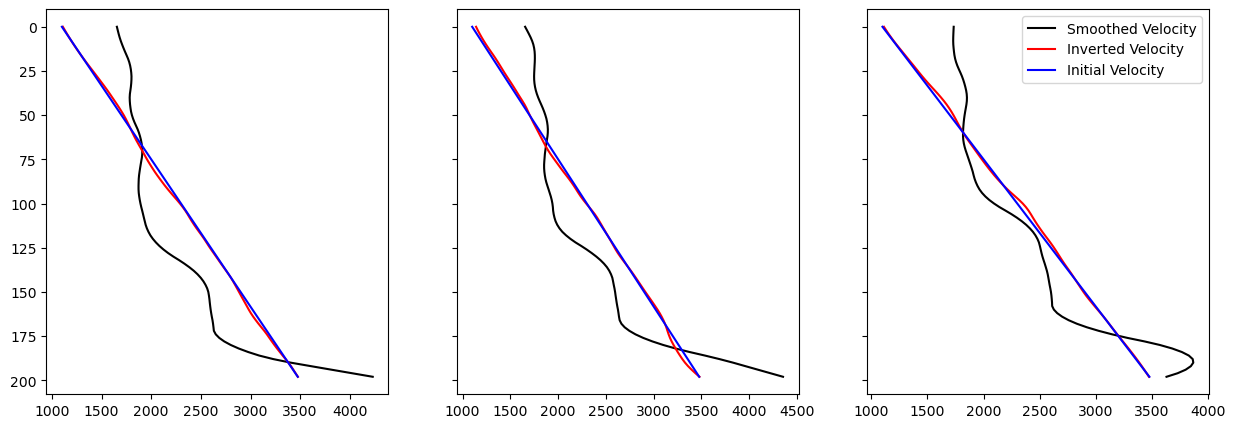

In [18]:
# Plot vel profiles
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_smooth[ix], z, 'k', label = 'Smoothed Velocity')
    ax.plot(vel_gauss_surface[ix], z, 'r', label = 'Inverted Velocity')
    ax.plot(vel_initial[ix], z, 'b', label = 'Initial Velocity')
axs[-1].invert_yaxis()
plt.legend()
plt.show()

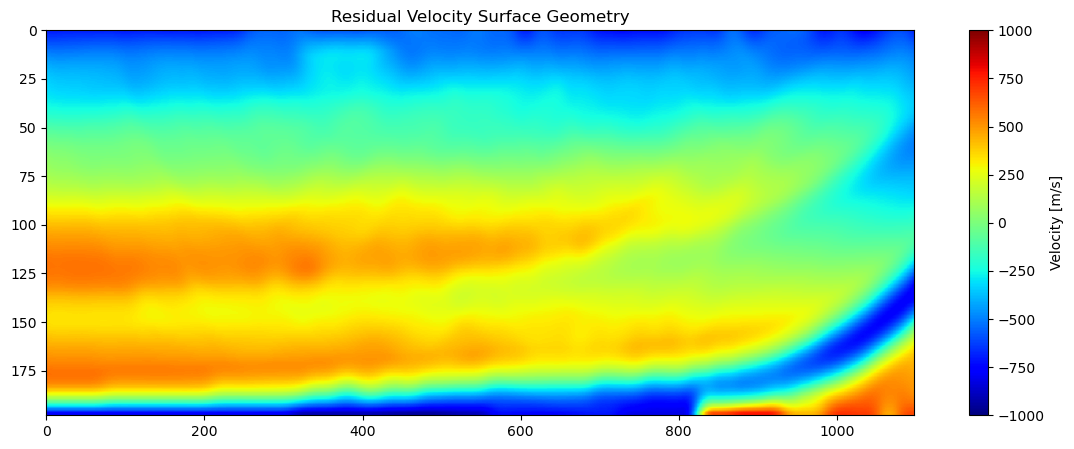

In [19]:
# Plot the residual velocity
plt.figure(figsize=(14, 5))

plt.imshow(vel_gauss_surface.T - vel_smooth.T, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]), vmin=-1000, vmax=1000)
plt.colorbar(label='Velocity [m/s]')
plt.title('Residual Velocity Surface Geometry')
plt.axis('tight')
plt.show()

## 2) VSP Geometry

In [20]:
#%% Geometry
geometry = 'VSP'  # Modified, now is horizontal
ns = 25
nr = 25
s = np.empty((2, ns))
r = np.empty((2, nr))
max_x = x[-1]
max_z = z[-1]
if geometry == 'Crosshole':
    s[0, :ns] = np.linspace(4 * dx, max_x - 4 * dx, ns)
    s[1, :ns] = 4 * dz
    r[0, :nr] = np.linspace(4 * dx, max_x - 4 * dx, nr)
    r[1, :nr] = max_z - 4 * dz

elif geometry == 'VSP':
    s[0, :ns] = np.linspace(7.5 * dx, max_x - 7.5 * dx, ns)
    s[1, :ns] = 2.5 * dz
    r[0, :nr] = max_x / 2
    r[1, :nr] = np.linspace(2.5 * dz, max_z - 2.5 * dz, nr)

elif geometry == 'Surrounded':
    s[0, :ns//2] = 5 * dx
    s[1, :ns//2] = np.linspace(5 * dz, max_z - 5 * dz, ns//2)
    r[0, :nr//2] = max_x - 5 * dx
    r[1, :nr//2] = np.linspace(5 * dz, max_z - 5 * dz, nr//2)

    s[1, ns//2:] = 5 * dz
    s[0, ns//2:] = np.linspace(5 * dx, max_x - 5 * dx, ns//2)
    r[1, nr//2:] = max_z - 5 * dz
    r[0, nr//2:] = np.linspace(5 * dx, max_x - 5 * dx, nr//2)

elif geometry == 'Surface':
    r[0, :] = np.linspace(4 * dx, max_x - 4 * dx, nr)
    r[1, :] = 0
    s[0, :] = np.linspace(2 * dx, max_x - 2 * dx, ns)
    s[1, :] = 0

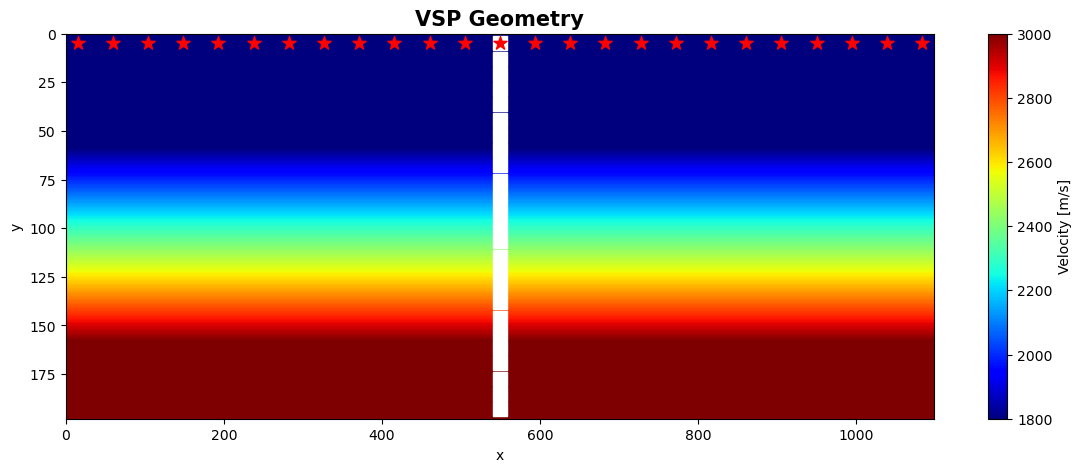

In [21]:
# Create the survey
survey = survey_geom(s, r, minoffset=20)

# Plot geometry
plt.figure(figsize=(14, 5))
im = plt.imshow(vel_initial.T, cmap='jet', vmin=vmin, vmax=vmax, extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar(im, label='Velocity [m/s]')
plt.scatter(r[0], r[1], c='w', s=100, marker='s')
plt.scatter(s[0], s[1], c='r', s=100, marker='*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('VSP Geometry', fontsize=15, fontweight='bold')
plt.axis('tight')
plt.show()

In [22]:
#%% Inverse crime
lmax = 1e3
nl = 2000
thetas = np.hstack([np.arange(-45, -0.5, 0.1), np.arange(0.5, 45, 0.1)])
avasurvey = survey_raytrace(survey, vel_smooth.T, x, z, lmax, nl, thetas, dzout=1., ray_rec_mindistance=3., tolerance_z=3., debug=True)

# # Display observed traveltimes
# fig, ax = plt.subplots(1, 1, figsize=(15, 3))
# for isrc in range(ns):
#     display_survey_tobs(avasurvey, s[0][isrc], ax=ax)
# plt.title('Observed Travel Times')
# plt.show()

No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
survey_raytrace: 600 Source-receiver pairs in survey, 169 Source-receiver paired with ray...


In [23]:
# Create tomographic matrix 
Robs = tomographic_matrix(avasurvey, dx, dz, 0, 0, nx, nz, x, z, plotflag=False, vel=vel_smooth)

tobs_real = extract_tobs(avasurvey)
tobs_real_R = Robs @ (1/vel_smooth.ravel())

Any zero singular values: False
Condition number of the matrix: 25.99


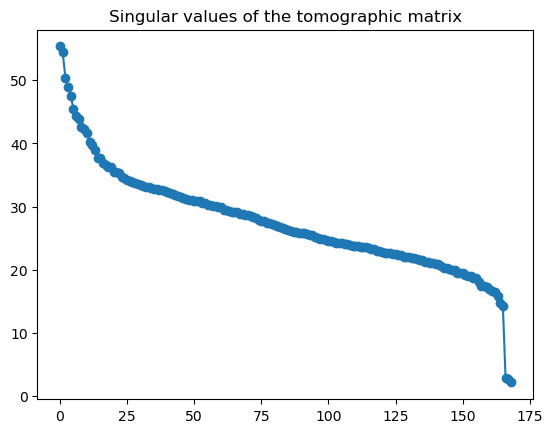

In [24]:
# Compute and plot the singular values of the tomographic matrix
U, s, Vh = np.linalg.svd(Robs.toarray(), full_matrices=False)
print('Any zero singular values:', np.any(s == 0))

# Print the condition number of the matrix
print(f"Condition number of the matrix: {np.round(np.linalg.cond(Robs.toarray()),2)}")

plt.figure()
plt.plot(s, 'o-')
# plt.yscale('log')
plt.title('Singular values of the tomographic matrix')
plt.show()

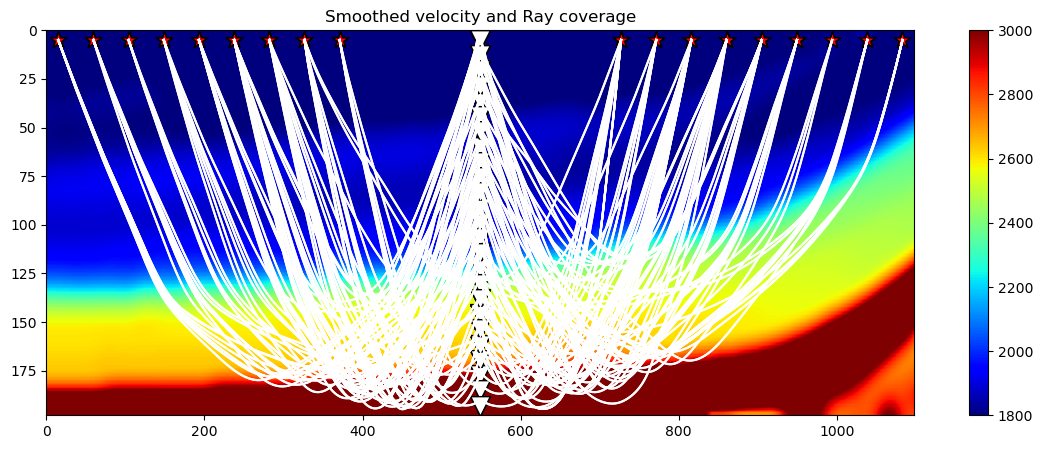

In [25]:
# Ray coverage
plt.figure(figsize=(14, 5))
im = plt.imshow(vel_smooth.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]), vmin=vmin, vmax=vmax)
plt.colorbar(im)
for ss in avasurvey:
    src = ss.src
    plt.scatter(src[0], src[1], marker='*', s=150, c='r', edgecolors='k')
    plt.scatter(ss.rec[0], ss.rec[1], marker='v', s=200, c='w', edgecolors='k')

    for irec, rec in enumerate(ss.rec):
        plt.plot(ss.ray[:,0], ss.ray[:,1], 'w')
plt.axis('auto')
plt.title('Smoothed velocity and Ray coverage')
plt.show()

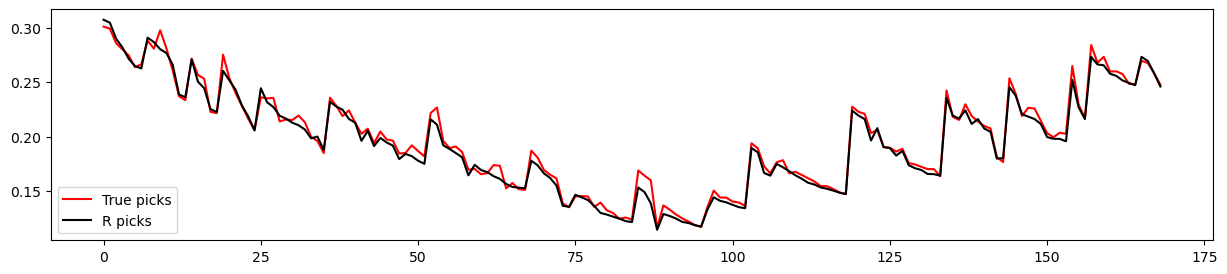

In [26]:
# Plot observed and predicted picks
plt.figure(figsize=(15, 3))
plt.plot(tobs_real, 'r', label= "True picks")
plt.plot(tobs_real_R, 'k', label = "R picks")
plt.legend()
plt.show()

In [27]:
#%% Initial rays and traveltimes
initsurvey = survey_raytrace(survey, vel_initial.T, x, z, lmax, nl, thetas, dzout=1., ray_rec_mindistance=3., debug=True)

# Match surveys
avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey, debug=True)

# Tomographic matrix and traveltimes
Rinit = tomographic_matrix(initsurvey_matched, dx, dz, 0, 0, nx, nz, x, z,
                           plotflag=False, vel=vel_initial, figsize=(15, 3))

# Extract traveltimes
tobs = extract_tobs(avasurvey_matched)
tobs_init = extract_tobs(initsurvey_matched)
tinit = Rinit @ (1/vel_initial.ravel())

No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
survey_raytrace: 600 Source-receiver pairs in survey, 138 Source-receiver paired with ray...
match_surveys: 169 Rays in survey1, 138 Rays in survey2, 52 Matched rays...


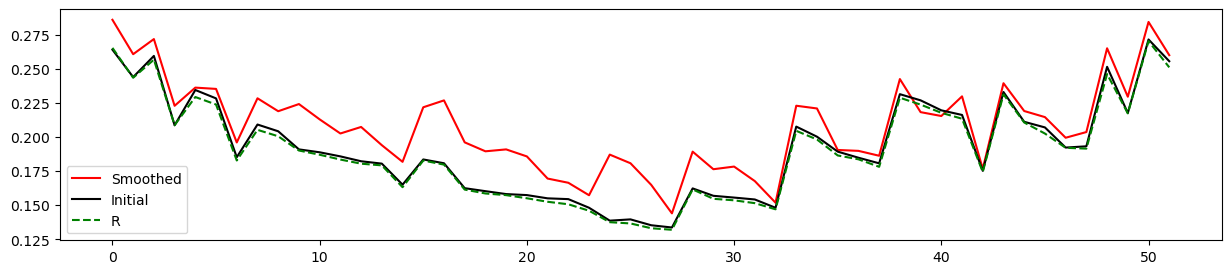

In [28]:
# Observed traveltimes vs Initial Guess
initial_Rinit = Rinit.copy()
initial_tobs_init = tobs_init.copy()

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r', label = 'Smoothed')
plt.plot(tobs_init, 'k', label = 'Initial')
plt.plot(tinit, '--g', label = 'R')
plt.legend()
plt.show()

Iteration 1/6
RefrTomo-fun: Computing...
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
No valid rays found for this source-receiver pair.
survey_raytrace: 600 Source-receiver pairs in survey, 128 Source-receiver paired with ray...
match_surveys: 169 Rays in survey1, 128 Rays in survey2, 50 Matched rays...
tomographic_matrix: 50 rows, 55000 columns
RefrTomo-fun: Misfit 0.0027
RefrTomo-fun: Elapsed time 36.938353061676025 s...
Itera

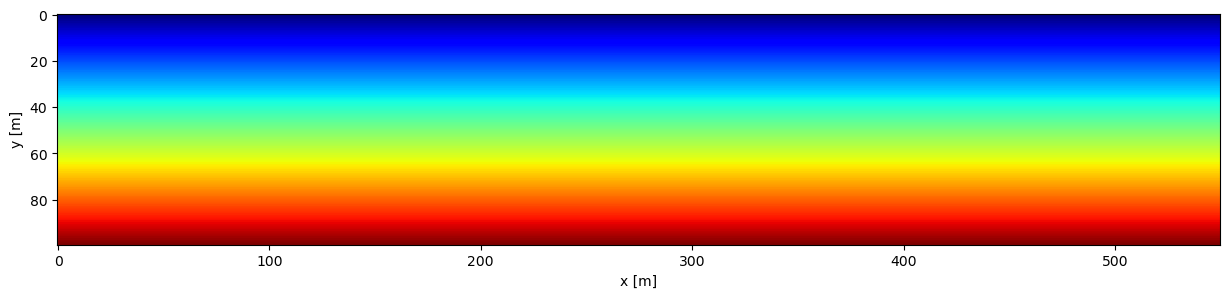

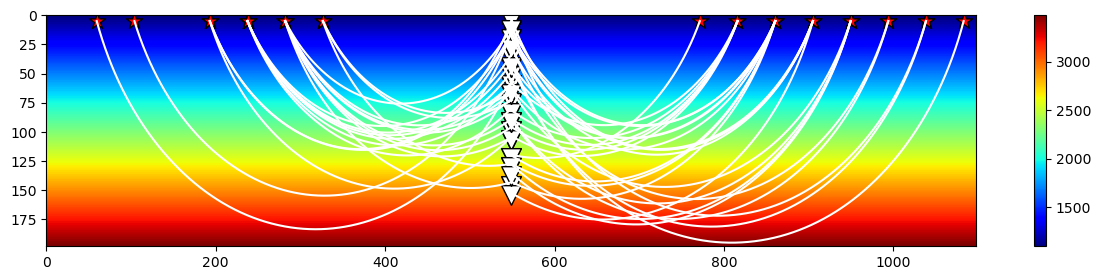

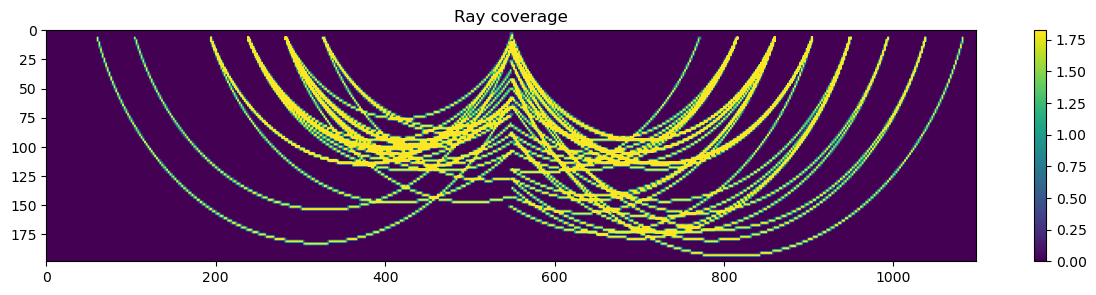

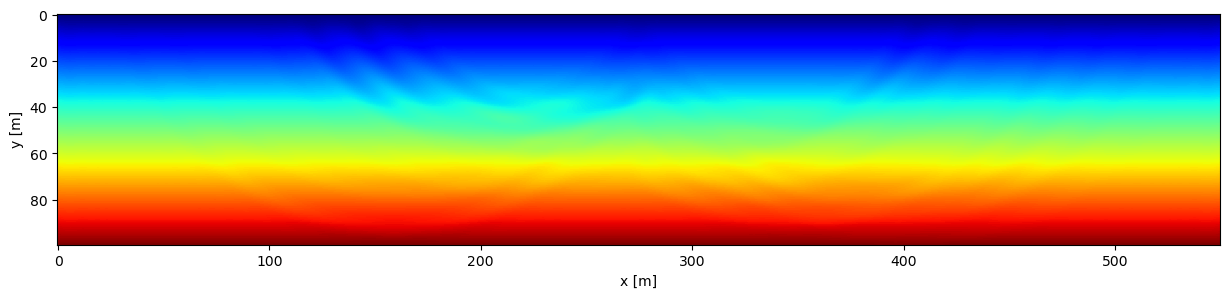

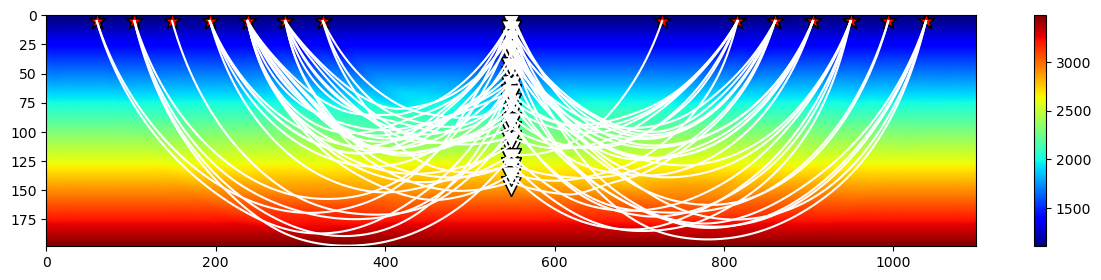

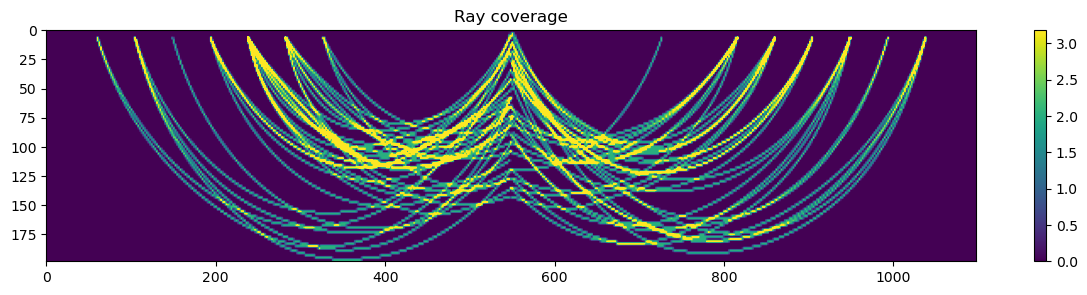

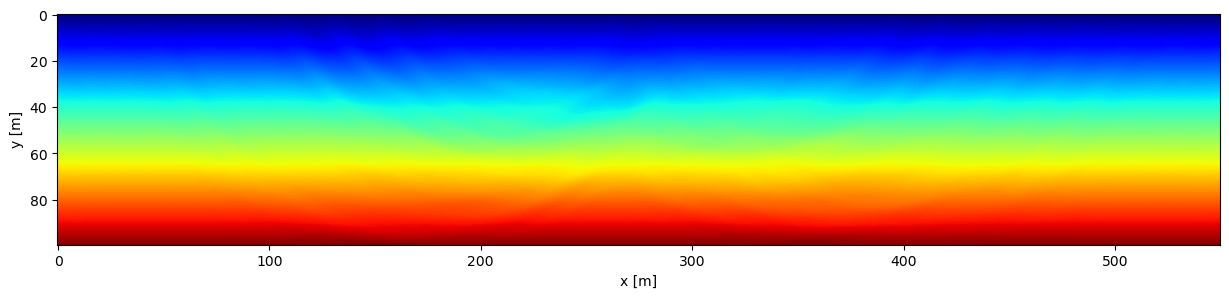

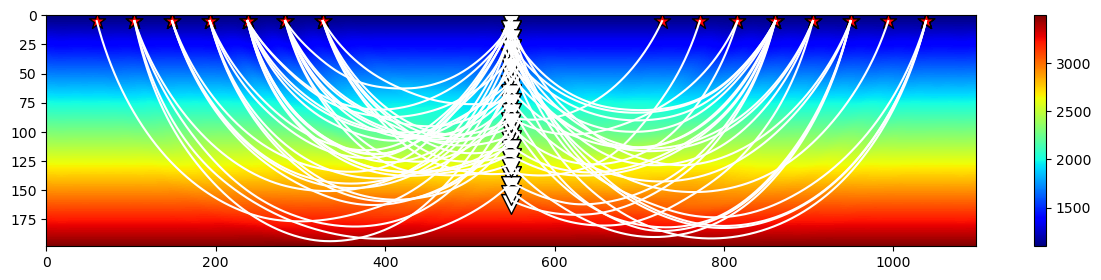

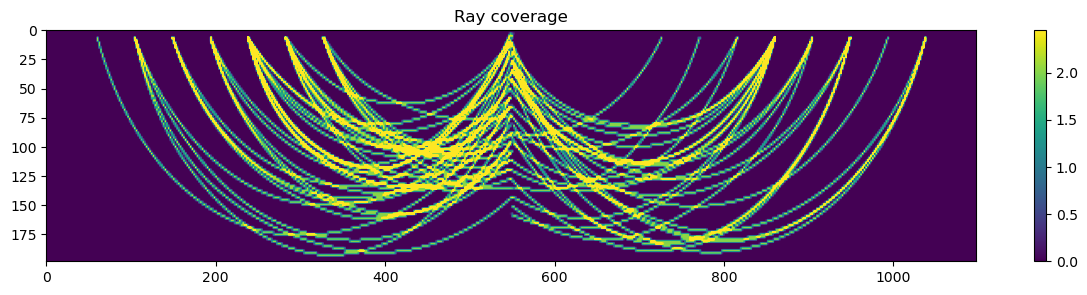

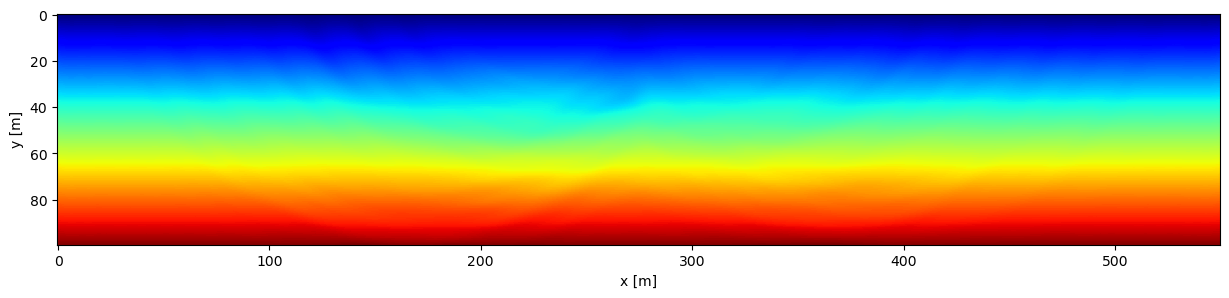

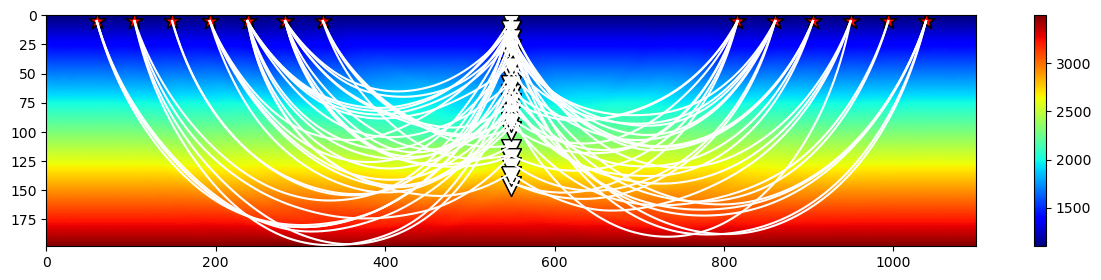

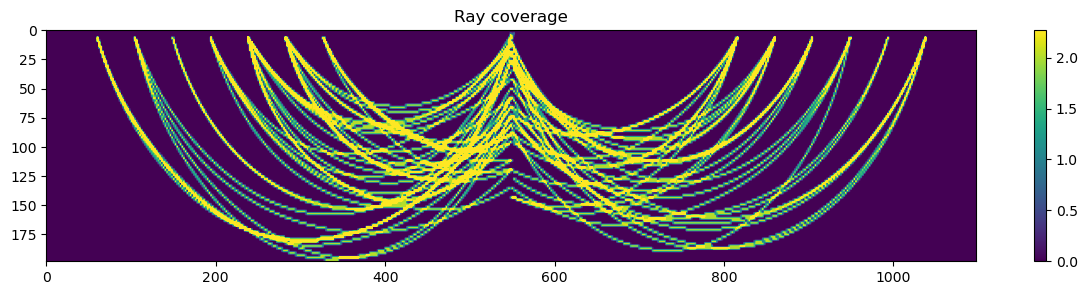

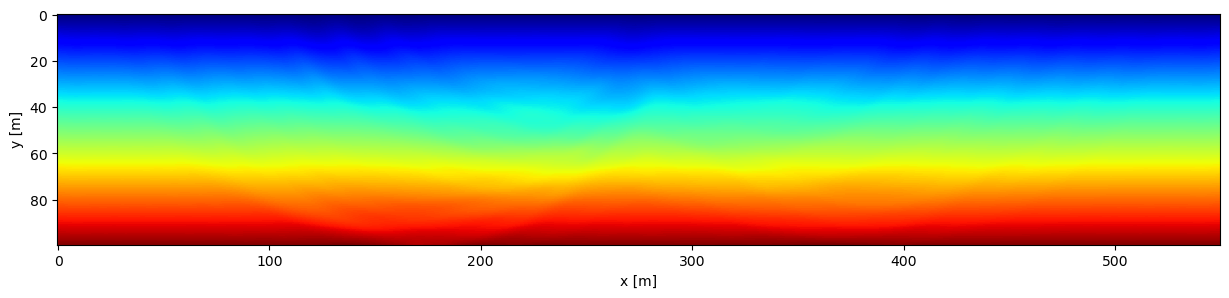

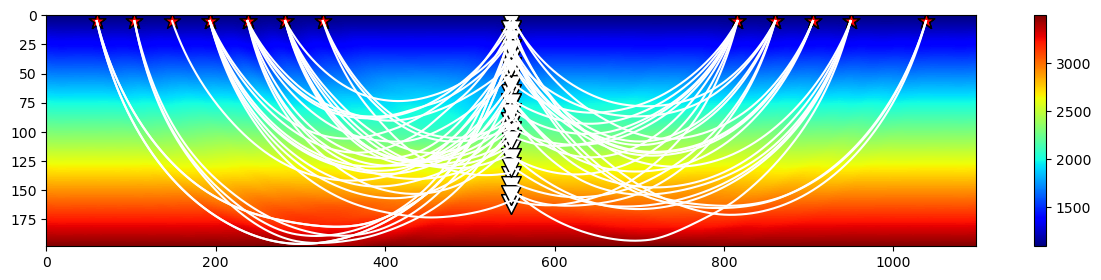

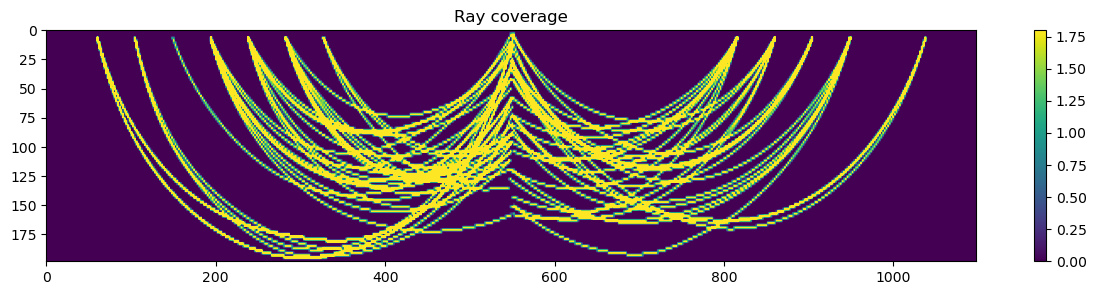

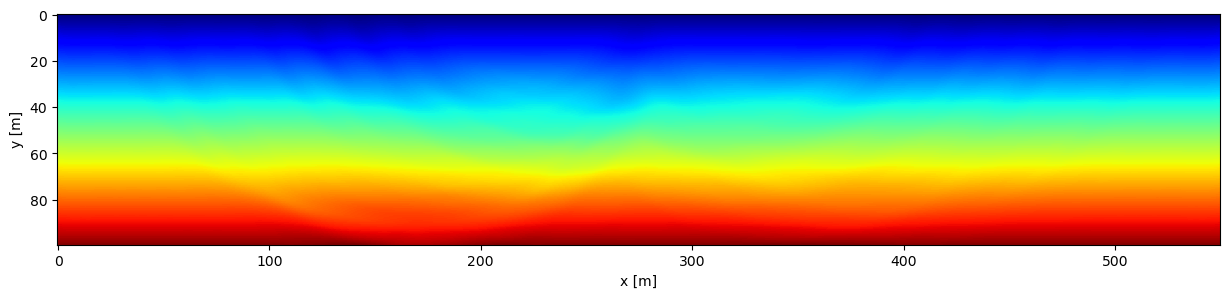

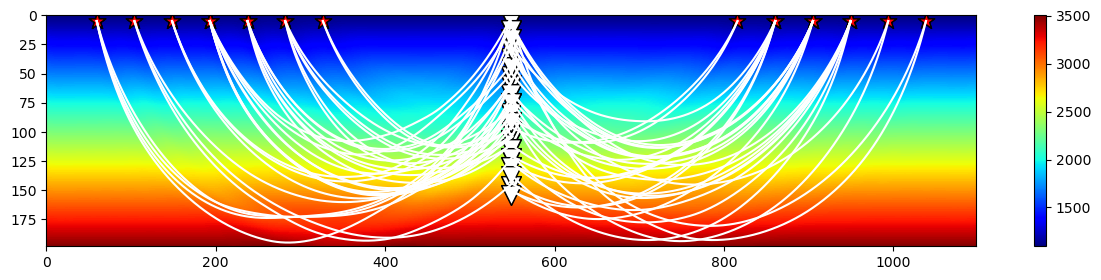

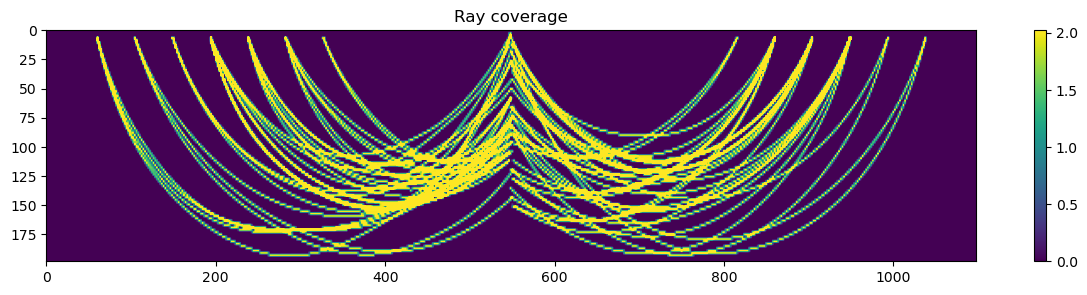

In [29]:
#%% Proper Gauss-Newton Method
RTomo_vsp = RefrTomo(survey, avasurvey, x, z, lmax, nl, thetas, dzout=1.,
                 ray_rec_mindistance=3., tolerance_z=3, epsL=3e1, weightsL=(20, 10), returnJ=True,
                 debug=True)
vel_gauss_vsp, misfit_gauss_vsp = RTomo_vsp.solve(vel_initial, niter=6, damp=1.3e0, lsqr_args=dict(iter_lim=30, show=False))

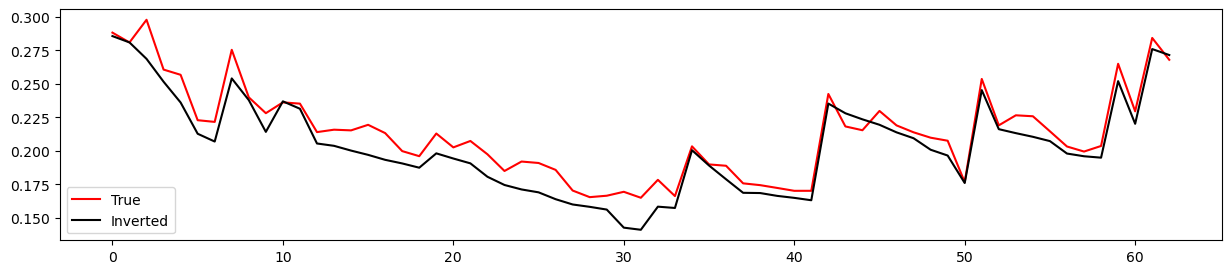

In [30]:
# Extract the final traveltimes from the RTomo object
tobs = RTomo_vsp.tobs
tinv = RTomo_vsp.tinv

# Plot the true and inverted traveltimes
plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r', label = 'True')
plt.plot(tinv, 'k', label = 'Inverted')
plt.legend()
plt.show()

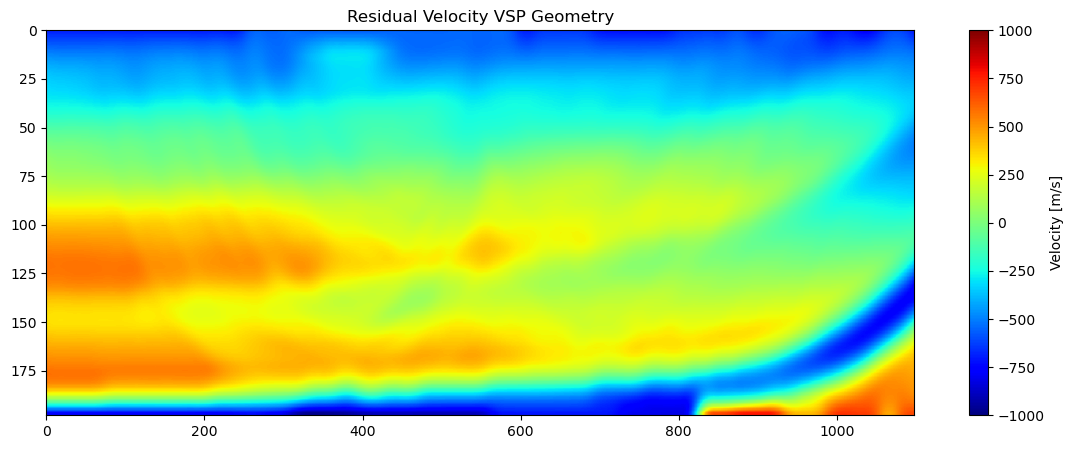

In [31]:
# Plot the residual velocity
plt.figure(figsize=(14, 5))

plt.imshow(vel_gauss_vsp.T - vel_smooth.T, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]), vmin=-1000, vmax=1000)
plt.colorbar(label='Velocity [m/s]')
plt.title('Residual Velocity VSP Geometry')
plt.axis('tight')
plt.show()